# Comparison of W'balance algorithms

## Initialization

In [1]:
from athletic_pandas.models import Athlete, WorkoutDataFrame
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Introduction

This is a short article that describes and compares the different W'balance algorithms that are circulating. It is in no way conclusive and not intended to rate each of the algorithms. The algorithms that are discussed are the Skiba<sup>1</sup> algorithm, an optimization (approximation) of the Skiba algorithm by Dave Waterworth<sup>2</sup> and the Froncioni/Clarke algorithm<sup>3</sup>.

## Short primer on critical power and W'balance

blabla

## Skiba

The Skiba W'balance algorithm is the most known algorithm to calculate W'balance. It is the only algorithm that has been scientifically validated<sup>4</sup>. The formula's for the algorithm are:

\begin{equation}
W'_{bal}(t) = W' - \sum_{u=0}^t W'_{exp}(u) * e^{-\frac{t-u}{\tau_{W'}}}$
\end{equation}

\begin{equation}
\tau_{W'} = 546*e^{-0.01*D_{CP}}+316
\end{equation}

\begin{equation}
W'_{exp}(t) =
    \begin{cases}
    0 & \text{where } P(t) < CP \\
    P(t) - CP & \text{else}
    \end{cases}
\end{equation}

Where $W’_{bal}(t)$ is equal to $W'_bal$ at time *t*, **W’**  is the amount of available energy above CP , **t**  the time for wich $W'_{bal}$ is calculated, **u** the iterator of the summation, $W’_{exp}(t)$  amount of energy above CP that is used at time u (*expended*), **e**  the Euler number and **$\tau_{W’}$** a time constant that describes the recovery speed. The numbers 546, -0.01 and 316 are determined in Skiba's original article and do not change between persons. $D_{CP}$ is the difference between CP and the average power of the intervals in which the power was below CP. $D_{CP}$ can be calculated dynamically (the average up untill time t) or calculated once for the entire workout and used as a static value. Skiba recommends using a static value for $D_{CP}$<sup>{citation needed}</sup>.

### Waterworth optimization of Skiba

The original algorithm of Skiba is quite expensive to compute, even on fast computers, since the summation has to be run for every time t again. Mathematician Dave Waterworth helped core developer of GoldenCheetah Mark Liversedge to develop an optimization of the Skiba algorithm<sup>2</sup>. This reformulation is an approximation of the Skiba algorithm so results can vary a little in extreme cases, especially when $\tau_{W'}$ is very low. I will show a comparison of these two algorithms later in this article.

\begin{equation}
S(t) = \sum_0^t W'_{exp}(t)*e^{\frac{t}{\tau_{W'}}}
\end{equation}
\begin{equation}
W'_{bal}(t) = S(t)*e^\frac{t}{\tau_{W'}}
\end{equation}

## Froncioni

The second algorithm is only implemented in [GoldenCheetah](http://www.goldencheetah.org/) and apart from the source code of this software I could not find any references to this algorithm anywhere. Nevertheless, this algorithm is the default algorithm for the calculation of W'balance in GoldenCheetah (The "W'bal formula" is by default set to "Differential" which corresponds to this algorithm, instead of "Integral", which corresponds to the Waterworth optimization of the Skiba algorithm).

\begin{equation}
W'_{bal}(t) = 
    \sum_0^t (CP - P(t)) * 
    \begin{cases}
    1 & \text{where } P(t)>CP\\
    {\frac{W' - W'_{bal}(t-1)}{W'_{bal}(t-1)}} & \text{else}
    \end{cases}
\end{equation}

## Comparison

As an example I will create a workout which starts with a warming up of 10 minutes at 100W, followed by two times 5 times 1 minute at 400W with 1 minute rest at 100W and 4 minutes rest between the two sets and ending with a cooling down of 10 minutes at 100W.

In [14]:
warming_up = [100] * 600
intervals = ([400]*60 + [100]*60)*5 + [100]*240 + ([400]*60 + [100]*60)*5
cooling_down = [100] * 600

wdf = WorkoutDataFrame(dict(
    power=warming_up + intervals + cooling_down
))
wdf.athlete = Athlete(cp=350, w_prime=20000)

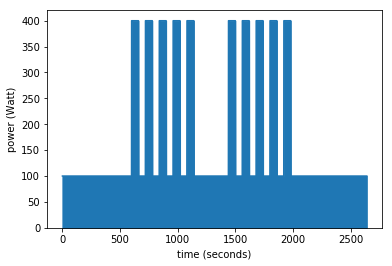

In [26]:
fig_power = wdf.power.plot.area()
fig_power.set_ylabel('power (Watt)');
fig_power.set_xlabel('time (seconds)');

In [16]:
wdf = wdf.assign(
    w_balance_skiba=wdf.compute_w_prime_balance('skiba'),
    w_balance_waterworth=wdf.compute_w_prime_balance('waterworth'),
    w_balance_froncioni=wdf.compute_w_prime_balance('froncioni'),
)

I will start with comparing the two versions of the Skiba algorithm. First the plot showing W'balance for both algorithms. This plot shows that the difference between these to algorithms is very small, with the Waterworth plot covering the Skiba plot almost completely.

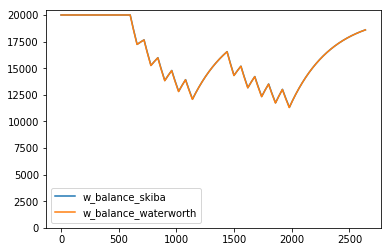

In [29]:
wdf.loc[:, ['w_balance_skiba', 'w_balance_waterworth']].plot(ylim=0)

When the residual plot for these two algorithms is plotted...

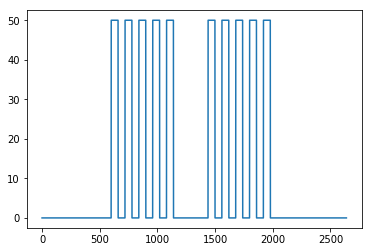

In [24]:
(wdf.w_balance_skiba - wdf.w_balance_waterworth).plot()

Comparison of Skiba with Froncioni reveals large differences between these two algorithtms. Both the expenditure and the recovery of $W'_{bal}$ are faster for the Froncioni algorithm. The difference in the expenditure is especially striking because one would expect that it is linear and therefore identical for both algorithms. Hower, the difference can be explained by the fact that the Skiba algorithm assumes that although there is a netto decrease in $W'_{bal}$ for intervals where $P>CP$, there is also recovery of previously expended $W'$ during those intervals.

The difference in the recovery of $W'_{bal}$ is a consequence of how the recovery is modelled. For Skiba this is done with the term $e^{-\frac{t-u}{\tau_{W'}}}$ part of the equation, where $\tau_{W'}$ regulates the speed of recovery. My expectation is that for different values of $\tau_{W'}$ (or different values for the constants numbers 546, -0.01 and 316) the recovery can be changed to similar speed as the Froncioni model. Similarly, the recovery speed in the Froncioni model is regulated by the term $\frac{W' - W'_{bal}(t-1)}{W'_{bal}(t-1)}$ and it is possible to change the recovery speed by multiplying this term by e.g. a factor $\alpha$: $\alpha*\frac{W' - W'_{bal}(t-1)}{W'_{bal}(t-1)}$.

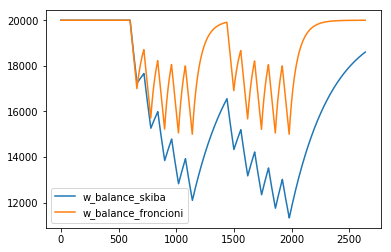

In [28]:
wdf.loc[:, ['w_balance_skiba', 'w_balance_froncioni']].plot()

## Conclusion

From the three algorithms that were compared, there were no significant differences between the original Skiba algorithm and the optimization of this algorithm by Waterworth. There were however big differences between both versions of the Skiba algorithm and the Froncioni/Clarke algorithm. These difference could be decreased by adding a model parameter to the Froncioni algorithm and fitting it to experimental data comparable to Skiba et al. (2014)<sup>4</sup>. 

## References

1. Skiba, P. F., Chidnok, W., Vanhatalo, A., & Jones, A. M. (2012). Modeling the expenditure and reconstitution of work capacity above critical power. Medicine and science in sports and exercise, 44(8), 1526-1532.
2. http://markliversedge.blogspot.nl/2014/10/wbal-optimisation-by-mathematician.html
3. GoldenCheetah source code: https://github.com/GoldenCheetah/GoldenCheetah/blob/160eb74cab712bfaa9eab64dd19310e5d42ed193/src/Metrics/WPrime.cpp#L257
4. Skiba, P. F., Jackman, S., Clarke, D., Vanhatalo, A., & Jones, A. M. (2014). Effect of work and recovery durations on W'reconstitution during intermittent exercise. Medicine and science in sports and exercise, 46(7), 1433-1440.